# **MILESTONE 1 PHASE 1**


___
## **Introduction**

Author : I Gusti Agung Istri Ratu Apsari Dewi

Batch : 002

Objectives : 


1.  Identifying which segment of the population the marketing campaign going to address and why.
2.  Create an optimum model to classify Term Deposit subscriptions suitable to client data information provided.


___

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Data Processing
import pandas as pd

# Linear algebra
import numpy as np
import os
np.random.seed(42)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "H8_Milestone1_P1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

**Input Variables**

*Bank Client Data*:
1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric) 
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

*Related with the last contact of the current campaign*:
9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

*other attributes*:
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**Output variable (desired target)**:
17. y: has the client subscribed a term deposit? (binary: "yes","no")

## Data Loading

Loading dataset of client information

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/RatuApsari/H8_FTDS002_RatuApsari/main/"
BANK_PATH = os.path.join("datasets")
BANK_URL = DOWNLOAD_ROOT + "PYTN/datasets/bank-full.tar.gz"

def fetch_bank_data(bank_url=BANK_URL, bank_path=BANK_PATH):
    if not os.path.isdir(bank_path):
        os.makedirs(bank_path)
    tgz_path = os.path.join(bank_path, "bank-full.tar.gz")
    urllib.request.urlretrieve(bank_url, tgz_path)
    bank_tgz = tarfile.open(tgz_path)
    bank_tgz.extractall(path=bank_path)
    bank_tgz.close()

In [3]:
fetch_bank_data()

In [4]:
def load_bank_data(bank_path=BANK_PATH):
    csv_path = os.path.join(bank_path, "bank-full.csv")
    return pd.read_csv(csv_path, sep=";")

In [5]:
df= load_bank_data()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Below is the data information:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In total, there are total 45.211 instances in the dataset. It contains 7 numerical columns and 10 object columns. We will convert object data into numerical using encoder provided by sklearn in preprocessing step. If we look at the data info there are no missing values and no duplicated values either as all attributes have the same count.

In [7]:
df.duplicated().sum()

0

Now, let's look at individual unique values. There are several columns filled with 'unknown' value, that could be interpreted as missing value. We will treat this using imputation or drop it instead.

In [8]:
for col in df.columns:
  print(col,"==>",df[col].unique())

age ==> [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
job ==> ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ==> ['married' 'single' 'divorced']
education ==> ['tertiary' 'secondary' 'unknown' 'primary']
default ==> ['no' 'yes']
balance ==> [ 2143    29     2 ...  8205 14204 16353]
housing ==> ['yes' 'no']
loan ==> ['no' 'yes']
contact ==> ['unknown' 'cellular' 'telephone']
day ==> [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month ==> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
duration ==> [ 261  151   76 ... 1298 1246 1556]
campaign ==> [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21

Next thing to do is checking summary of numerical attributes to briefly see how the data is distributed.

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Count means how many value is found. Mean is the average value. Std stands for standards deviation showing how dispersed the values are. Min is the minimum value. Max is the maximum value. The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall. For example, 25% of the client have a balance lower than 72, while 50% are lower than 448 and 75% are lower than 1,428. These are often called the 25th percentile (or first quartile), the median, and the 75th percentile (or third quartile).

Saving figure attribute_histogram_plots


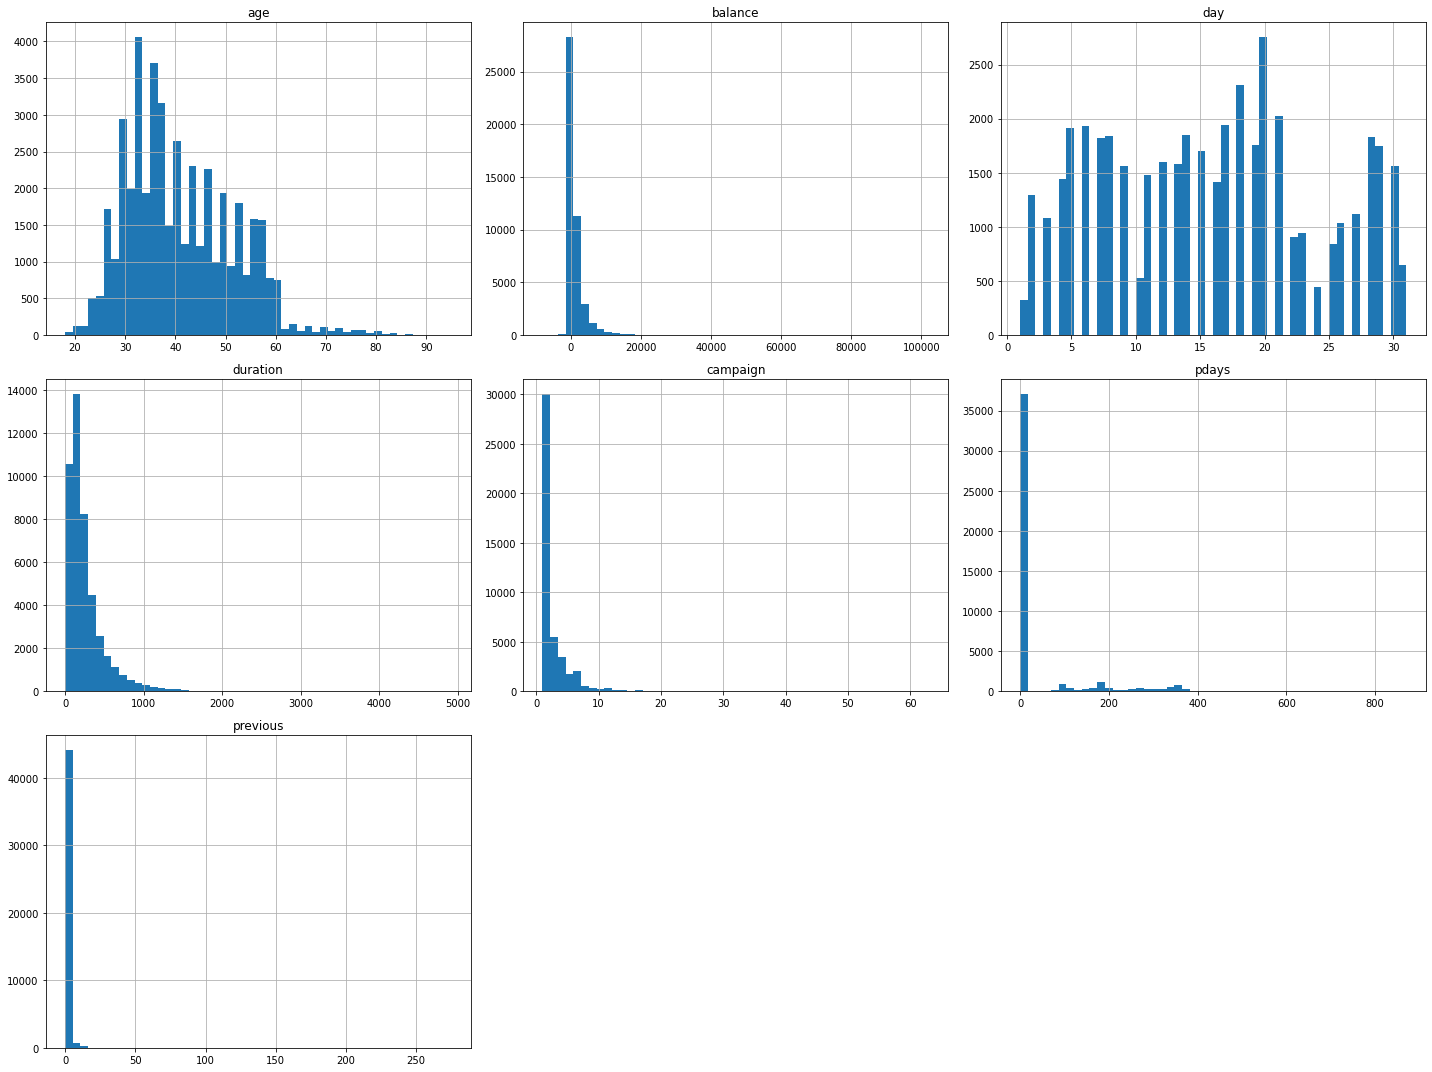

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

As shown in the above graph:
1. These attributes have different scales. So we will need to scale the attributes in preprocessing section.
2. Many histograms are tailed heavy: They are not showing normal distribution where mean and median is not located at the same data point. Moreover, they are more likely extend further to the right side of the median (left skewed).


## Data Cleaning

To decide which strategy applied when handling missing values, we need to evaluate how strategy will impact to overall data. Each section will explain individual suggested treatment.

1. Handling missing values for "Job"

In [11]:
import plotly.express as px

fig = px.pie(df, values='balance', names='job')
fig.show()

In [12]:
grouped_multiple = df.groupby(['job']).agg({'balance': ['mean', 'min', 'max']})
grouped_multiple.columns = ['balance_mean', 'balance_min', 'balance_max']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

              job  balance_mean  balance_min  balance_max
0          admin.   1135.838909        -1601        64343
1     blue-collar   1078.826654        -8019        66653
2    entrepreneur   1521.470074        -2082        59649
3       housemaid   1392.395161        -1941        45141
4      management   1763.616832        -6847       102127
5         retired   1984.215106        -1598        81204
6   self-employed   1647.970868        -3313        52587
7        services    997.088108        -2122        57435
8         student   1388.060768         -679        24025
9      technician   1252.632092        -2827        45248
10     unemployed   1521.745971        -1270        44134
11        unknown   1772.357639         -295        19706


In [13]:
df['job'].mode()

0    blue-collar
dtype: object

Summary:

Unknown job is 0.8% spread among the data with average balance 1772 euro, min -295, max 19706. The most frequently appeared category is blue-collar and the range value of unknown job can still be fit into blue-collar category. So we will use mode as impute strategy.

2. Handling missing values in "Education"

In [14]:
fig = px.pie(df, values='balance', names='education')
fig.show()

In [15]:
grouped_multiple = df.groupby(['education']).agg({'balance': ['mean', 'min', 'max']})
grouped_multiple.columns = ['balance_mean', 'balance_min', 'balance_max']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

   education  balance_mean  balance_min  balance_max
0    primary   1250.949934        -2604        71188
1  secondary   1154.880786        -8019        81204
2   tertiary   1758.416435        -6847       102127
3    unknown   1526.754443        -1445        64343


In [16]:
df['education'].mode()

0    secondary
dtype: object

Summary:

Unknown education is 4.58% spread among the data with average balance 1526 euro, min -1445, max 64343. The most frequently appeared category is secondary and the range value of unknown education can still be fit into secondary category. So we will use mode as impute strategy also.

3. Handling missing values in "Contact"

In [17]:
fig = px.pie(df, values='balance', names='contact')
fig.show()

In [18]:
grouped_multiple = df.groupby(['contact']).agg({'balance': ['mean', 'min', 'max']})
grouped_multiple.columns = ['balance_mean', 'balance_min', 'balance_max']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

     contact  balance_mean  balance_min  balance_max
0   cellular   1397.926993        -8019       102127
1  telephone   1803.704061        -1965        98417
2    unknown   1183.550384        -3372        58544


In [19]:
df['contact'].mode()

0    cellular
dtype: object

Summary:

Unknown contact is 25.3% spread among the data, so the option is to drop the feature and other feature related to contact such as day, month and duration.

4. Handling missing values in "Poutcome" (Previous Marketing Campaign outcome)

In [20]:
fig = px.pie(df, values='balance', names='poutcome')
fig.show()

In [21]:
grouped_multiple = df.groupby(['poutcome']).agg({'balance': ['mean', 'min', 'max']})
grouped_multiple.columns = ['balance_mean', 'balance_min', 'balance_max']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

  poutcome  balance_mean  balance_min  balance_max
0  failure   1465.805550        -1884        37378
1    other   1487.411413        -1882        81204
2  success   1939.301125         -405        81204
3  unknown   1318.722043        -8019       102127


In [22]:
df['poutcome'].mode()

0    unknown
dtype: object

Summary:

Previous marketing campaign outcome is a valuable information that can improve marketing campaign moving forward. However unknown previous outcome is 79.3% spread among the data. Since there are too many missing data, so we will drop poutcome attributes from input feature along with other feature related to it.

Now after we know what to do to handle missing values in categorical atributes. First we need to replace "unknown" into missing values that can be identified by pandas.

In [23]:
df = df.replace("unknown", np.nan)

As seen below, Pandas now can identify that there are several missing values in job, education, contact, and poutcome.

In [24]:
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

After identifying missing values, next thing to do is removing several features from dataframe that is unnecessary and unrelated in modelling Term Deposit Classifier.

In [25]:
df = df.drop(["contact","day","month","duration","campaign","pdays","previous","poutcome"],axis=1)

The target features which is 'y' column is still in object data type ("yes", "no"). Therefore we need to change it into binary (1 and 0) to make the modelling easier to calculate. 

In [26]:
from sklearn.preprocessing import OrdinalEncoder
ordinal = OrdinalEncoder(categories=[['no','yes']])
df['y'] = ordinal.fit_transform(df[['y']])
df['y']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
45206    1.0
45207    1.0
45208    1.0
45209    0.0
45210    0.0
Name: y, Length: 45211, dtype: float64

Here, we create a data copy to test some of preprocessing step that will be integrated as full pipeline in the end.

In [27]:
data = df.copy()

Two columns that have missing values will be filled by most frequent value in each columns.

In [28]:
data["job"] = data["job"].fillna(data['job'].mode()[0])
data["education"] = data["education"].fillna(data['education'].mode()[0])

In [29]:
data

,age,job,marital,education,default,balance,housing,loan,y
0,58,management,married,tertiary,no,2143,yes,no,0.0
1,44,technician,single,secondary,no,29,yes,no,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,0.0
3,47,blue-collar,married,secondary,no,1506,yes,no,0.0
4,33,blue-collar,single,secondary,no,1,no,no,0.0
...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,1.0
45207,71,retired,divorced,primary,no,1729,no,no,1.0
45208,72,retired,married,secondary,no,5715,no,no,1.0
45209,57,blue-collar,married,secondary,no,668,no,no,0.0


Now, let's see the unique value available in the new dataset. No missing values seen here.

In [30]:
for col in data.columns:
  print(col,"==>",data[col].unique())

age ==> [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
job ==> ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
marital ==> ['married' 'single' 'divorced']
education ==> ['tertiary' 'secondary' 'primary']
default ==> ['no' 'yes']
balance ==> [ 2143    29     2 ...  8205 14204 16353]
housing ==> ['yes' 'no']
loan ==> ['no' 'yes']
y ==> [0. 1.]


## Exploration Data Analysis

**Percentage of Term Deposit Subscriptions**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



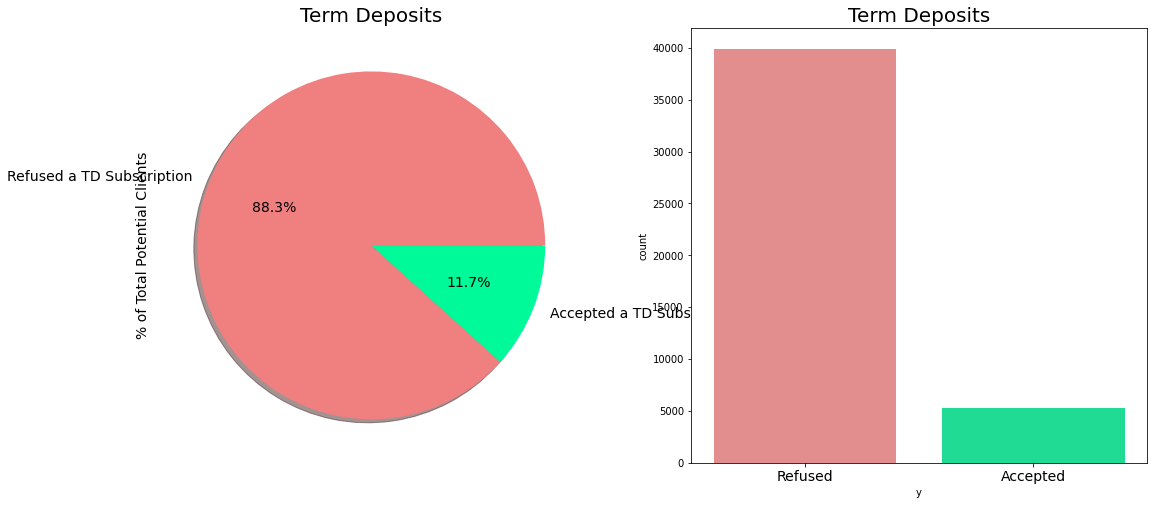

In [91]:
f, ax = plt.subplots(1,2,figsize=(18,8))
colors = ["#F08080","#00FA9A"]
labels = 'Refused a TD Subscription','Accepted a TD Subsciptions'
data['y'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True, colors=colors, labels=labels, fontsize=14)
ax[0].set_title('Term Deposits', fontsize=20)
ax[0].set_ylabel('% of Total Potential Clients', fontsize=14)

sns.countplot(data['y'], ax=ax[1], palette=colors)
ax[1].set_title('Term Deposits', fontsize= 20)
ax[1].set_xticklabels(['Refused','Accepted'], fontsize=14)
plt.show()

88.3% refused to subscribe to term deposits while 11.7% accepted to subscribe term deposits.

**Client Age Group and Potential Term Deposit Subscription**

In [92]:
data['agegroup']=pd.cut(df['age'], bins=[18,30,40,50,60,100], 
                            labels=[20,30,40,50,60])

**Age Group:**

*   **20** : This category will include all the ages ranging from 18-29
*   **30** : This category will include all the ages ranging from 30-39
*   **40** : This category will include all the ages ranging from 40-49
*   **50** : This category will include all the ages ranging from 50-59
*   **60** : This category will include all the ages ranging from 60-95 (95 is our maximum age)


In [93]:
data_by_age = data.groupby(["agegroup","y"]).agg({"default": "count"}).reset_index()

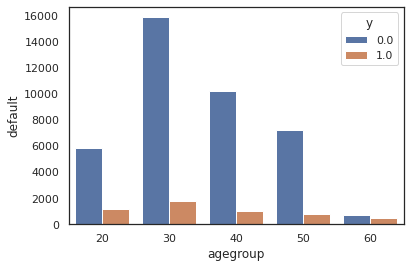

In [110]:
sns.barplot(x="agegroup", y="default", hue="y", data=data_by_age)

In [99]:
cross_age = pd.crosstab(data['y'], data['agegroup']).apply(lambda x: x/x.sum()*100)
cross_age

agegroup,20,30,40,50,60
y,,,,,
0.0,83.784554,89.755187,90.933357,89.946696,57.744108
1.0,16.215446,10.244813,9.066643,10.053304,42.255892


In [101]:
data["agegroup"].value_counts()

30    17687
40    11239
50     8067
20     7018
60     1188
Name: agegroup, dtype: int64

Most of the potential clients the bank targeted have 30-39 years old. Around 16% of potential clients in 20s subscribed to term deposit subscriptions.
Around 42% of the potential clients in 60s and older subscribed to term deposit subscriptions

The youngest and eldest population are more likely to open a term deposit account.

**Type of Occupation Leads to More Term Deposit Subscriptions**

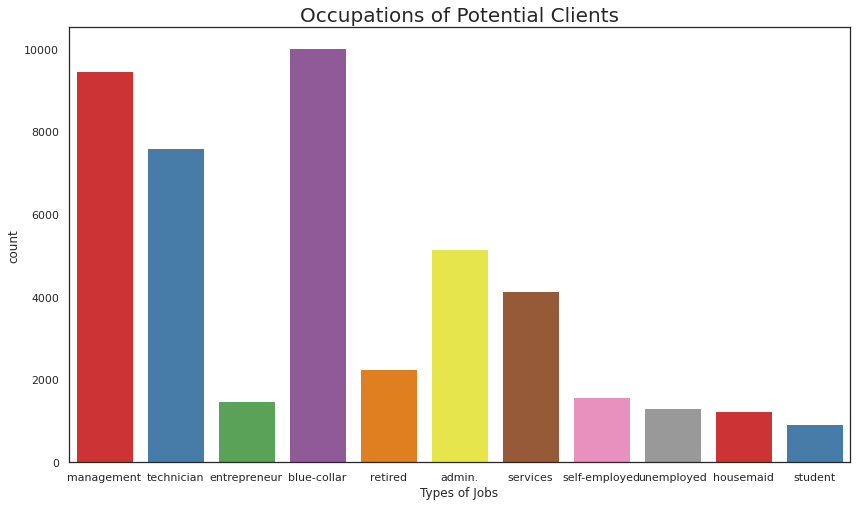

In [102]:
sns.set(style="white")
fig, ax = plt.subplots(figsize=(14,8))
sns.countplot(x='job', data=data, palette="Set1")
ax.set_title("Occupations of Potential Clients", fontsize=20)
ax.set_xlabel("Types of Jobs")
plt.show()

In [103]:
cross_job = pd.crosstab(data['y'], data['job']).apply(lambda x: x/x.sum()*100)
cross_job

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
y,,,,,,,,,,,
0.0,87.797331,92.59481,91.728312,91.209677,86.244449,77.208481,88.157061,91.116996,71.321962,88.943004,84.497314
1.0,12.202669,7.40519,8.271688,8.790323,13.755551,22.791519,11.842939,8.883004,28.678038,11.056996,15.502686


People working in Management, Blue-collars and Technician received the most offers from the marketing department to subcribe term deposits. Students, unemployed, housemaids and entreprenuers received the less amount of offers from marketing department. 

28.7% of the students subscribed term deposits (which was expected since the youngest segment of the population is most likely to be a student). 22.8% of people who were retired willing to subscribe term deposits(This was also expected since the eldest segment of the population is most likely to be retiree). 15.5% of unemployed were willingto subscribe term deposits (People tend to save more when they are not able to find jobs since there is most likely no source of income)

**Balance Categories**

Balance could be a factor that might influences client's decision in subscribing to a term deposit. To simplify analysis, we will split data into following categories:

1. No Balance : no balance or negative balance
2. Low Balance : greater than 0 but lower than 1000
3. Average Balance : greater than 1000 but lower than 5000
4. High Balance : greater than 5000

In [105]:
data['balance_cat']=np.nan

list = [data]

for column in list:
  column.loc[column['balance'] <= 0, 'balance_cat'] = 'no balance'
  column.loc[(column['balance'] > 0)&(column['balance'] <= 1000), 'balance_cat'] = 'low balance'
  column.loc[(column['balance'] > 1000)&(column['balance'] <= 5000), 'balance_cat'] = 'average balance'
  column.loc[(column['balance'] > 5000), 'balance_cat'] = 'high balance'

data.head()
data['balance_cat'].value_counts()  

low balance        23300
average balance    11786
no balance          7280
high balance        2845
Name: balance_cat, dtype: int64

Marketing campaign is excessively targeting clients with low balance segment.
This could indicate the lower the balance, the more likely the potential client to refuse subscribing a term deposit. The marketing campaign targets fewer people who have a high balance.

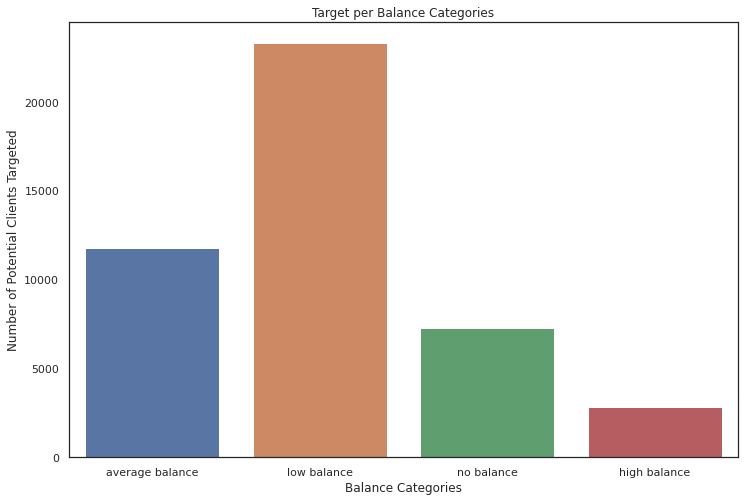

In [107]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x="balance_cat", data=data)

plt.title("Target per Balance Categories")
plt.xlabel("Balance Categories")
plt.ylabel("Number of Potential Clients Targeted")
plt.show()

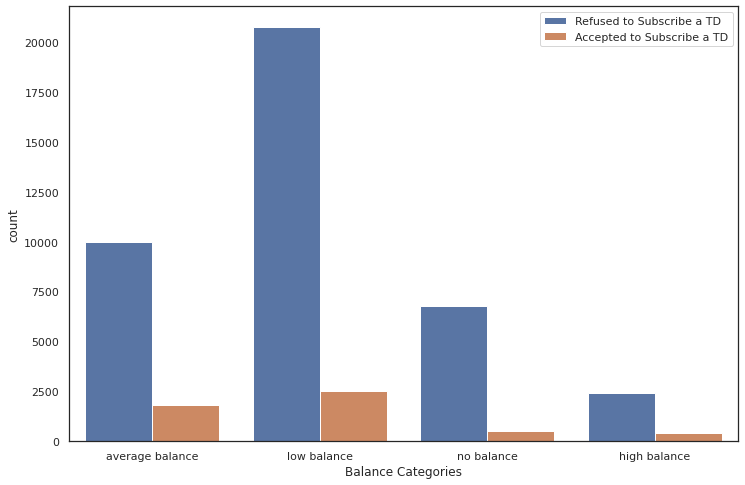

In [109]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x="balance_cat", data=data, hue='y')

legend_name = plt.legend()
legend_name.get_texts()[0].set_text('Refused to Subscribe a TD')
legend_name.get_texts()[1].set_text('Accepted to Subscribe a TD')
plt.xlabel("Balance Categories")
plt.show()

## Data Preprocessing

### Create Test Set

Dataset splits into train data and test data using shuffle split to avoid overfitting of the data. So the model could learn to adapt to new data moving forward.

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df,df['y']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [36]:
bank = strat_train_set.drop("y",axis=1)
bank_labels = strat_train_set["y"].copy() 

X_test = strat_test_set.drop("y",axis=1)
y_test = strat_test_set["y"].copy() 

### Transformer Pipeline

Transformer pipeline is useful in simplifying data cleaning process and also data preprocessing before model training, simply by calling the function and automatically transform the data.

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

num_attribs = ['age', 'balance']
cat_attribs = ['job','marital','education','default','housing','loan']

old_num_pipeline = Pipeline([
                         ('selector', OldDataFrameSelector(num_attribs)),
                         ('std_scaler', StandardScaler()),
])

old_cat_pipeline = Pipeline([
                         ('selector', OldDataFrameSelector(cat_attribs)),
                         ('imputer', SimpleImputer(strategy="most_frequent")),
                         ('cat_encoder', OrdinalEncoder()),
])

In [39]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [40]:
old_bank_prepared = old_full_pipeline.fit_transform(bank)
old_bank_prepared

array([[-0.46043404, -0.16441038,  9.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.58964093,  0.89962705,  8.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29237054, -0.36548575,  9.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.38647112, -0.41925793,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.3073392 ,  0.38895426,  4.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.79797972, -0.28922702,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Define Model

Model trained below is using default hyperparameter from sklearn.

In [41]:
# logistic regression
logreg = LogisticRegression()

# SVM
from sklearn.svm import SVC
svm = SVC()

# Decision Tree
from sklearn import tree
dt = tree.DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Naive Bayes
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

# XGBoost
import xgboost
from xgboost import XGBClassifier

xgb = xgboost.XGBRFClassifier()


## Model Training

In [42]:
logreg.fit(old_bank_prepared,bank_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
svm.fit(old_bank_prepared, bank_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
dt.fit(old_bank_prepared,bank_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [45]:
rf.fit(old_bank_prepared,bank_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
knn.fit(old_bank_prepared,bank_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [47]:
nb.fit(old_bank_prepared,bank_labels)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [48]:
xgb.fit(old_bank_prepared,bank_labels)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

### Model Selection

**Logistic Regression**

In [49]:
y_pred_logreg = logreg.predict(old_full_pipeline.fit_transform(X_test))

In [50]:
print(confusion_matrix(y_test,y_pred_logreg))

[[7984    1]
 [1058    0]]


In [112]:
print("Hasil dari Classification Report")
print(classification_report(y_test,y_pred_logreg))
print("AUC Score", roc_auc_score(y_test,y_pred_logreg))

Hasil dari Classification Report
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      7985
         1.0       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043

AUC Score 0.4999373825923607


Summary:

Logistic regression has quite high accuracy (88%). However the prediction could be misleading as there is no True Negative data in confusion matrix. Also the AUC Score is still below baseline (<50%).



**Support Vector Machine**

In [113]:
y_pred_svm = svm.predict(old_full_pipeline.fit_transform(X_test))

In [114]:
print(confusion_matrix(y_test,y_pred_svm))

[[7985    0]
 [1058    0]]


In [115]:
print("Hasil dari Classification Report")
print(classification_report(y_test,y_pred_svm, zero_division=0))
print("AUC Score", roc_auc_score(y_test,y_pred_svm))

Hasil dari Classification Report
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      7985
         1.0       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043

AUC Score 0.5


Summary:

Support Vector Machine has quite high accuracy (88%) and base AUC Score (0.5), however the prediction could be misleading as there is no True Negative data in confusion matrix. 

**Decision Tree**

In [116]:
y_pred_dt = dt.predict(old_full_pipeline.fit_transform(X_test))

In [117]:
print(confusion_matrix(y_test,y_pred_dt))

[[7194  791]
 [ 835  223]]


In [118]:
print("Hasil dari Classification Report")
print(classification_report(y_test,y_pred_dt))
print("AUC Score", roc_auc_score(y_test,y_pred_dt))

Hasil dari Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      7985
         1.0       0.22      0.21      0.22      1058

    accuracy                           0.82      9043
   macro avg       0.56      0.56      0.56      9043
weighted avg       0.82      0.82      0.82      9043

AUC Score 0.5558571541867845


Summary:

Decision Tree has a good accuracy (82%) and base AUC Score (0.55). The prediction in False Negative is around 791 (9.6% of the data). Decision Tree could be our optimum model but we need further evaluation.

**Random Forest Classifier**

In [58]:
y_pred_rf = rf.predict(old_full_pipeline.fit_transform(X_test))

In [59]:
print(confusion_matrix(y_test,y_pred_rf))

[[7687  298]
 [ 874  184]]


In [119]:
print("Hasil dari Classification Report")
print(classification_report(y_test,y_pred_rf))
print("AUC Score", roc_auc_score(y_test,y_pred_rf))

Hasil dari Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      7985
         1.0       0.38      0.17      0.24      1058

    accuracy                           0.87      9043
   macro avg       0.64      0.57      0.58      9043
weighted avg       0.84      0.87      0.85      9043

AUC Score 0.568296534262612


Summary:

Random Forest has a better accuracy (87%) than Decision Tree and AUC Score (0.56). The prediction in False Negative is around 298 (3.6% of the data). Random Forest could be our optimum model but we need further evaluation.

**K Nearest Neighbors**

In [61]:
y_pred_knn = knn.predict(old_full_pipeline.fit_transform(X_test))

In [62]:
print(confusion_matrix(y_test,y_pred_knn))

[[7726  259]
 [ 920  138]]


In [120]:
print("Hasil dari Classification Report")
print(classification_report(y_test,y_pred_knn))
print("AUC Score", roc_auc_score(y_test,y_pred_knn))

Hasil dari Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      7985
         1.0       0.35      0.13      0.19      1058

    accuracy                           0.87      9043
   macro avg       0.62      0.55      0.56      9043
weighted avg       0.83      0.87      0.84      9043

AUC Score 0.5489994827257629


Summary:

K-Nearest Neighbors has same accuracy (87%) as Random Forest and AUC Score (0.54). The prediction in False Negative is around 259 (3.15% of the data). K-Nearest Neighbors could be our optimum model but we need further evaluation.

**Bernoulli Naive Bayes**

In [64]:
y_pred_nb = nb.predict(old_full_pipeline.fit_transform(X_test))

In [65]:
print(confusion_matrix(y_test,y_pred_nb))

[[7985    0]
 [1058    0]]


In [121]:
print("Hasil dari Classification Report")
print(classification_report(y_test,y_pred_nb, zero_division=0))
print("AUC Score", roc_auc_score(y_test,y_pred_nb))

Hasil dari Classification Report
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      7985
         1.0       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043

AUC Score 0.5


Summary:

Bernoulli Naive Bayes has same accuracy (88%) as SVM and AUC Score (0.5). The prediction is grouped only in True Positives and False Positives.

**XGBoost**

In [67]:
y_pred_xgb = xgb.predict(old_full_pipeline.fit_transform(X_test))

In [68]:
print(confusion_matrix(y_test,y_pred_xgb))

[[7984    1]
 [1058    0]]


In [122]:
print("Hasil dari Classification Report")
print(classification_report(y_test,y_pred_xgb, zero_division=0))
print("AUC Score", roc_auc_score(y_test,y_pred_xgb))

Hasil dari Classification Report
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      7985
         1.0       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043

AUC Score 0.4999373825923607


Summary:

XGBoost has quite high accuracy (88%). However the prediction could be misleading as there is no True Negative data in confusion matrix. Also the AUC Score is still below baseline (<50%).

### Cross Validation

Another method in selecting optimum model could be by using cross validation score. Below is the result: 

In [131]:
from sklearn.model_selection import cross_val_score

# Logistic Regression
logreg_scores= cross_val_score(logreg, old_bank_prepared, bank_labels, cv=3)
logreg_mean= logreg_scores.mean()

# Support Vector Machine
svm_scores= cross_val_score(svm, old_bank_prepared, bank_labels, cv=3)
svm_mean= svm_scores.mean()

# Decision Tree
dt_scores= cross_val_score(dt, old_bank_prepared, bank_labels, cv=3)
dt_mean= dt_scores.mean()

# Random Forest
rf_scores= cross_val_score(rf, old_bank_prepared, bank_labels, cv=3)
rf_mean= rf_scores.mean()

# K-Nearest Neighbors
knn_scores= cross_val_score(knn, old_bank_prepared, bank_labels, cv=3)
knn_mean= knn_scores.mean()

# Bernoulli Naive Bayes
nb_scores= cross_val_score(nb, old_bank_prepared, bank_labels, cv=3)
nb_mean= nb_scores.mean()

# XGBoost
xgb_scores= cross_val_score(xgb, old_bank_prepared, bank_labels, cv=3)
xgb_mean= xgb_scores.mean()

# Create dataframe with results
g = {'Classifiers':['Logistis Reg.','SVC','Decision Tree', 'Random Forest',
                    'KNN','BernouliiNB','XGB'],
     'Crossval Mean Scores':[logreg_mean, svm_mean, dt_mean, rf_mean, knn_mean,
                             nb_mean, xgb_mean]}

result_df = pd.DataFrame(data=g)
result_df = result_df.sort_values(by=['Crossval Mean Scores'],ascending=False)
result_df

,Classifiers,Crossval Mean Scores
6,XGB,0.883073
1,SVC,0.883018
5,BernouliiNB,0.883018
0,Logistis Reg.,0.882908
3,Random Forest,0.872871
4,KNN,0.872235
2,Decision Tree,0.820891


## Model Evaluation

Most optimum model based on cross validation scores is XGB, therefore we need to fine tuning the hyperparameter to increase accuracy.

In [147]:
print("Classification Report Before Tuning")
print(classification_report(y_test,y_pred_xgb, zero_division=0))
print("AUC Score", roc_auc_score(y_test,y_pred_xgb))

Classification Report Before Tuning
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      7985
         1.0       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043

AUC Score 0.4999373825923607


In [141]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'gamma': [0, 3, 5],
    'max_depth': [3, 6, 10],
    'n_estimators': [100,500,1000]
    }
# Create a based model
xg = xgboost.XGBRFClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

best_model = grid_search.fit(old_bank_prepared,bank_labels)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  9.6min finished


In [145]:
#Best hyperparameters 
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])

Best gamma: 0
Best max_depth: 6
Best n_estimators: 1000


In [148]:
#Prediction using data test
y_predict = best_model.predict(old_full_pipeline.fit_transform(X_test))

# Model performance check
print("Classification Report After Tuning:")
print(classification_report(y_test, y_predict))
print("AUC Score:", roc_auc_score(y_test, y_predict))

Classification Report After Tuning:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      7985
         1.0       0.50      0.01      0.02      1058

    accuracy                           0.88      9043
   macro avg       0.69      0.50      0.48      9043
weighted avg       0.84      0.88      0.83      9043

AUC Score: 0.5036897514597904


Compared to before tuning, AUC score improved by +0.004 and the accuracy remain the same at 88%. Also, weighted precision increased by +6%. 

# Model Inference

In this section, we are going to predict random test data below using full pipeline with predict.
Below is the random data:

In [150]:
some_data = X_test.sample(5)
some_data

,age,job,marital,education,default,balance,housing,loan
27691,46,management,divorced,tertiary,no,-94,yes,no
26723,34,technician,divorced,secondary,no,558,no,no
3011,36,services,married,secondary,no,338,no,no
24854,46,admin.,divorced,secondary,no,7378,no,no
39395,27,technician,divorced,secondary,no,1977,yes,no


In [151]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", old_full_pipeline),
        ("xgboost", xgboost.XGBRFClassifier(max_depth= 6, gamma= 0, n_estimators=1000, random_state=42))
    ])

full_pipeline_with_predictor.fit(bank, bank_labels)
full_pipeline_with_predictor.predict(some_data)

array([0., 0., 0., 0., 0.])

The result for all 5 random client is 0, meaning they are more likely to refuse the term deposit subscription offered by Marketing Department.

# Model Saving

In [76]:
my_model = full_pipeline_with_predictor

In [77]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

# Conclusion

1.   88.3% target client refused to subscribe to term deposits while 11.7% accepted to subscribe term deposits. Marketing campaign might not be targeting the right clients. 
2.   Based on Age Group, the youngest and eldest population are more likely to open a term deposit account. Meanwhile most of potential clients coming from age group 30-39 years old.
3.   Age and Job is somehow related. Students and retiree are more likely to subsribe a term deposit.
4.   Marketing campaign is excessively targeting clients with low balance segment. This could indicate the lower the balance, the more likely the potential client to refuse subscribing a term deposit. The marketing campaign targets fewer people who have a high balance.
5.   By point 1-4 we could suggest Marketing Department to approach client with average to high balance and considering youngest and eldest group on the next target campaign to improve subscription results.
6.   Best Model to predict Term Deposit Subscription is XGBooster with accuracy score 88%, AUC score 0.503, cross_val_score 0.883.

|Best hyperparameter|Value|
|---|---|
|max_depth|6|
|gamma|0|
|n_estimators|1000|

